In [1]:
from gensim.models import FastText
import matplotlib.pyplot as plt
from keras.models import load_model
from collections import Counter
from sklearn.decomposition import PCA
import pickle
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import nltk
import numpy as np
import os
import pandas as pd
import seaborn as sns
from collections import defaultdict
from keras import backend as K
from keras.layers import Input, Dense, LSTM,InputLayer, Bidirectional,TimeDistributed, Embedding
from keras.models import Model
from keras.layers import Embedding, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import brown
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

**Load the Data** 

In [2]:
train_dir = pd.read_csv("/kaggle/input/amharic-pos-labeled-data/train_set.csv")
dev_dir = pd.read_csv("/kaggle/input/amharic-pos-labeled-data/dev_set.csv")
test_dir = pd.read_csv("/kaggle/input/amharic-pos-labeled-data/test_set.csv")

In [3]:
print(train_dir.head(3))

    Word   Tag
0   ስህፈት     N
1     ቤቱ     N
2  ከአምስት  NUMP


**Extract Sentences and Tags**

In [4]:
def extract_sentences_and_tags(df):
    sentences, tags = [], []
    current_sentence, current_tags = [], []
    
    for _, row in df.iterrows():
        token, pos = row.iloc[0], row.iloc[1]
        
        if pd.isna(token):  
            if current_sentence:
                sentences.append(current_sentence)
                tags.append(current_tags) 
                current_sentence, current_tags = [], []
        else:
            current_sentence.append(token)
            current_tags.append(pos)
    
    if current_sentence:
        sentences.append(current_sentence)
        tags.append(current_tags)
    
    return sentences, tags

In [5]:
train_sentences, train_tags = extract_sentences_and_tags(train_dir)
dev_sentences, dev_tags = extract_sentences_and_tags(dev_dir)
test_sentences, test_tags = extract_sentences_and_tags(test_dir)

In [6]:
print(train_sentences[:2])

[['ስህፈት', 'ቤቱ', 'ከአምስት', 'ሚሊየን', 'ብር', 'በሚበልጥ', 'ወጪ', 'እያስገነባቸው', 'ያሉት', '34', 'የውሃ', '፣', '16', 'የጤናና', 'ስድስት', 'የትምህርት', 'ፕሮጀክቶችም', 'በመጪው', 'መጋቢት', 'ተጠናቀው', 'አገልግሎት', 'እንደሚሰጡ', 'አስታውቀዋል', '።'], ['እግዚአብሔር', 'ስለ', 'ገለጠላቸው', '፥', 'ስለ', 'እግዚአብሔር', 'ሊታወቅ', 'የሚቻለው', 'በእነርሱ', 'ዘንድ', 'ግልጥ', 'ነውና', '።']]


In [7]:
print(train_tags[:2])

[['N', 'N', 'NUMP', 'NUMCR', 'N', 'VP', 'N', 'VPS', 'VREL', 'NUMP', 'NP', 'PUNC', 'NUM', 'NPC', 'NUMCR', 'NP', 'NCS', 'NP', 'N', 'VS', 'N', 'VP', 'V', 'PUNC'], ['N', 'PREP', 'VPS', 'PUNC', 'PREP', 'N', 'NP', 'VREL', 'PRONPS', 'PREP', 'N', 'AUXC', 'PUNC']]


**Create unique mappings**

In [8]:
words, tags = set(), set()
for sentence, tag_seq in zip(train_sentences, train_tags):  
    for word, tag in zip(sentence, tag_seq):  
        words.add(word) 
        tags.add(tag)  

word2index = {}
for i, word in enumerate(words):
    word2index[word] = i + 2 
word2index['-PAD-'] = 0  
word2index['-OOV-'] = 1  

tag2index = {}
for i, tag in enumerate(tags):
    tag2index[tag] = i + 1 
tag2index['-PAD-'] = 0  

In [9]:
print(tag2index.keys())

dict_keys(['NS', 'ADVP', 'AUXC', 'ADJPCS', 'PRON', 'VRELC', 'PRONPCS', 'NP', 'PRONPC', 'NUMP', 'VRELCS', 'VC', 'NUM', 'NUMC', 'PRONS', 'VS', 'AUXCS', 'ADVPCS', 'N', 'VP', 'NPCS', 'VNCS', 'PRONCS', 'ADVPC', 'NC', 'VPCS', 'NPS', 'VPSs', 'NUMOR', 'INT', 'NUMPC', 'NPC', 'V', 'AUXS', 'PUNC', 'PREP', 'VPS', 'ADJS', 'PRONP', 'ADJP', 'VN', 'AUX', 'ADVC', 'VRELS', 'VPC', 'ADJPS', 'ADJ', 'ADVPS', 'CONJ', 'VCS', 'ADJPC', 'NUMCR', 'VREL', 'VNC', 'ADVS', 'NCS', 'ADV', 'ADJC', 'PRONC', 'ADJCS', 'VNS', 'PRONPS', '-PAD-'])


In [10]:
    def tokenize_sentences_and_tags(sentences, tags, word2index, tag2index):
        sentences_X, tags_y = [], []
        
        for sentence in sentences:
            sentence_ints = []
            for word in sentence:
                word_index = word2index.get(word, word2index['-OOV-'])
                sentence_ints.append(word_index) 
            sentences_X.append(sentence_ints)  
        
        for tag_seq in tags:
            tag_ints = []
            for tag in tag_seq:
                tag_index = tag2index[tag]
                tag_ints.append(tag_index)        
            tags_y.append(tag_ints)
    
        return sentences_X, tags_y

In [11]:
train_sentences_X, train_tags_y = tokenize_sentences_and_tags(train_sentences, train_tags, word2index, tag2index)
dev_sentences_X, dev_tags_y = tokenize_sentences_and_tags(dev_sentences, dev_tags, word2index, tag2index)
test_sentences_X, test_tags_y = tokenize_sentences_and_tags(test_sentences, test_tags, word2index, tag2index)

In [12]:
print(train_sentences_X[0])

[66388, 50943, 11822, 66292, 4992, 50907, 42785, 10751, 24297, 51546, 25826, 37228, 25127, 31569, 43712, 52934, 67893, 67478, 18019, 30039, 34172, 59925, 10608, 9576]


In [13]:
print(train_tags_y[0])

[19, 19, 10, 52, 19, 20, 19, 37, 53, 10, 8, 35, 13, 32, 52, 8, 56, 8, 19, 16, 19, 20, 33, 35]


 **Pad Sequences**

In [14]:
max_len = 0
for sentence in train_sentences:
    if len(sentence) > max_len:
        max_len = len(sentence)
MAX_LENGTH = max_len

train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')

dev_sentences_X = pad_sequences(dev_sentences_X, maxlen=MAX_LENGTH, padding='post')
dev_tags_y = pad_sequences(dev_tags_y, maxlen=MAX_LENGTH, padding='post')

test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

In [15]:
print(MAX_LENGTH)

215


In [16]:
print(train_sentences_X[0])

[66388 50943 11822 66292  4992 50907 42785 10751 24297 51546 25826 37228
 25127 31569 43712 52934 67893 67478 18019 30039 34172 59925 10608  9576
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [17]:
print(train_tags_y[0])

[19 19 10 52 19 20 19 37 53 10  8 35 13 32 52  8 56  8 19 16 19 20 33 35
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


**Data Analysis**

Counter({'N': 123063, 'PUNC': 58406, 'NP': 35278, 'V': 23361, 'NS': 20572, 'PREP': 20437, 'VP': 18784, 'ADJ': 12764, 'VS': 11195, 'VREL': 9986, 'NC': 9432, 'VPS': 9397, 'PRON': 9387, 'PRONP': 7075, 'VN': 5980, 'AUX': 5274, 'VRELS': 5094, 'ADV': 5091, 'CONJ': 4686, 'NUMCR': 4590, 'NUMP': 3997, 'PRONS': 3458, 'NPS': 3411, 'ADJP': 3363, 'NCS': 3065, 'PRONPS': 2985, 'NUM': 2859, 'NPC': 2702, 'VC': 1228, 'VNS': 1203, 'AUXS': 1099, 'VPC': 982, 'ADVP': 973, 'ADJS': 794, 'PRONC': 636, 'ADJC': 547, 'VPCS': 540, 'AUXC': 507, 'VCS': 471, 'INT': 344, 'NPCS': 317, 'NUMOR': 317, 'VRELC': 274, 'ADJPS': 259, 'PRONCS': 225, 'VRELCS': 221, 'ADJPC': 194, 'PRONPC': 163, 'VNC': 126, 'AUXCS': 88, 'ADVC': 88, 'ADJCS': 56, 'PRONPCS': 51, 'ADJPCS': 28, 'ADVS': 19, 'VNCS': 18, 'NUMPC': 16, 'NUMC': 12, 'ADVPC': 5, 'VPSs': 4, 'ADVPS': 3, 'ADVPCS': 2})


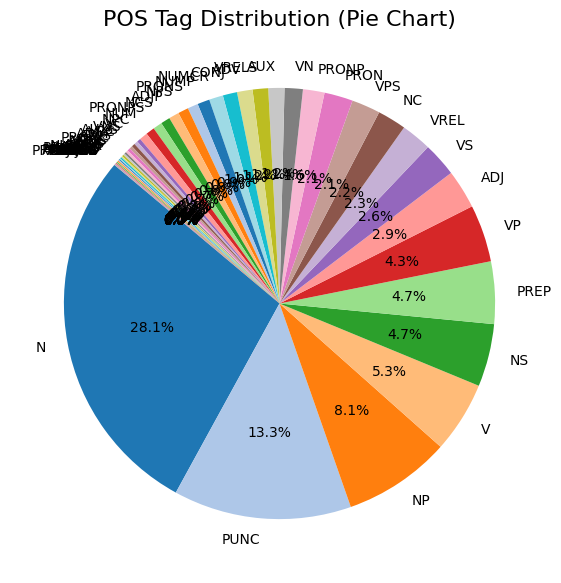

POS Tag Distribution (Counts):
   POS Tag   Count
0        N  123063
7     PUNC   58406
6       NP   35278
12       V   23361
20      NS   20572
..     ...     ...
57    NUMC      12
59   ADVPC       5
60    VPSs       4
58   ADVPS       3
61  ADVPCS       2

[62 rows x 2 columns]


In [18]:
def extract_pos_tags(df):
    pos_tags = df.iloc[:, 1].dropna()
    return pos_tags
train_pos_tags = extract_pos_tags(train_dir)
dev_pos_tags = extract_pos_tags(dev_dir)
test_pos_tags = extract_pos_tags(test_dir)
all_pos_tags = pd.concat([train_pos_tags, dev_pos_tags, test_pos_tags])
pos_counts = Counter(all_pos_tags)
print(pos_counts)
pos_df = pd.DataFrame(pos_counts.items(), columns=['POS Tag', 'Count']).sort_values(by='Count', ascending=False)
plt.figure(figsize=(10, 7))
plt.pie(pos_df['Count'], labels=pos_df['POS Tag'], autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title("POS Tag Distribution (Pie Chart)", fontsize=16)
plt.show()

print("POS Tag Distribution (Counts):")
print(pos_df)

 **Train FastText Model**

In [19]:
model = FastText(sentences=train_sentences, vector_size=100, window=5, min_count=1, sg=1)

In [20]:
print(f"Vocabulary size: {len(model.wv.index_to_key)}")

Vocabulary size: 67920


In [21]:
print(model.wv.index_to_key[:20])

['።', '፡፡', '፤', '፥', ')', '(', '፣', 'ላይ', 'ነው', 'ወደ', 'ጊዜ', 'ሁሉ', '»', '«', 'ግን', '?', 'አቶ', 'ዘንድ', 'እንደ', 'ውስጥ']


In [22]:
word_vector = model.wv['እኔም']
print(word_vector)

[-0.5369486   0.16380283  0.2559902  -0.57842505  0.26366857 -0.19483702
  0.3299305   0.68734425 -0.04664909 -0.11689771 -0.11858797  0.2724777
  0.4572042  -0.3307686   0.43017536 -0.5494546  -0.12492426 -0.23151536
 -0.41409436 -0.68289155 -0.57121426 -0.14351079  0.67957777  0.2418376
 -0.05351906  0.00474727  0.22612818  0.05168848  0.4211235  -0.48965716
  0.50621426  1.0908697   0.24681118 -0.6677684  -0.60906345  0.52506065
  0.18064286  0.32267317  0.1515189  -0.37915918 -0.20046546  0.02657621
 -0.24996094  0.43920782 -0.2611477  -0.52002335  0.6023751  -0.288105
  0.03061254  0.1956942   0.27781034 -0.2683224   0.0454638   0.2081853
 -0.15140423 -0.01113124  0.37082773  0.37676743 -0.4011342   0.23645854
  1.13452    -0.15015431  0.43777016 -0.45775056 -0.4019507   0.36549774
  0.19122009  0.17619182 -0.58662695  0.10577124 -0.12540625 -0.12243392
  0.19374369  0.17384146  0.20724921  0.16690204 -0.27535933  0.12680648
  0.1094632  -0.13584475  0.22300959 -0.42544976  0.2362

In [23]:
similar_words = model.wv.most_similar('ሰው', topn=4) 
print(similar_words)

[('ሰውራ', 0.9462165832519531), ('ሰውማ', 0.8789973855018616), ('ሰውስ', 0.8774082660675049), ('ሰውረህ', 0.8765712380409241)]


**Building an Embedding Matrix**

In [24]:
print(len(word2index))

67922


In [25]:
embedding_matrix = np.zeros((len(word2index), 100))
for word, idx in word2index.items():
    if word in model.wv:
        embedding_matrix[idx] = model.wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(size=(100,))

**One-Hot Encode the Tags**

In [26]:
print(model.vector_size)

100


In [27]:
def one_hot_encoding(tag_sents, n_tags):
    tag_one_hot_sent = []
    for tag_sent in tag_sents:
        tags_one_hot = []
        for tag in tag_sent:
            tags_one_hot.append(np.zeros(n_tags))
            tags_one_hot[-1][tag] = 1.0
        tag_one_hot_sent.append(tags_one_hot)
    return np.array(tag_one_hot_sent)

n_tags = len(tag2index)

train_tags_y = one_hot_encoding(train_tags_y, n_tags)
dev_tags_y = one_hot_encoding(dev_tags_y, n_tags)
test_tags_y = one_hot_encoding(test_tags_y, n_tags)

In [28]:
print(train_tags_y[1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


**Ignoring Padding Class for Accuracy Calculation**

In [29]:
def ignore_class_accuracy(to_ignore=tag2index['-PAD-']): 
    def ignore_accuracy(y_true, y_pred):
        y_true_class = tf.argmax(y_true, axis=-1)
        y_pred_class = tf.argmax(y_pred, axis=-1)
        ignore_mask = tf.cast(tf.not_equal(y_pred_class, to_ignore), 'int32')
        matches = tf.cast(tf.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

**Mapping Predictions to Tags**

In [30]:
index_to_tag = {i: tag for tag, i in tag2index.items()}

def logits_to_tags(tag_sentences, index_to_tag):
    tag_sequences = []
    for tag_sentence in tag_sentences:
        tag_sequence = []
        for tag in tag_sentence:
            max_index = np.argmax(tag)
            corresponding_tag = index_to_tag[max_index]
            tag_sequence.append(corresponding_tag)
        tag_sequences.append(tag_sequence)
    return tag_sequences

**Building the BiLSTM model**

In [31]:
print(f"Train sentences shape: {train_sentences_X.shape}")
print(f"Train tags shape: {train_tags_y.shape}")
print(f"Dev sentences shape: {dev_sentences_X.shape}")
print(f"Dev tags shape: {dev_tags_y.shape}")
print(f"Test sentences shape: {test_sentences_X.shape}")
print(f"Test tags shape: {test_tags_y.shape}")

Train sentences shape: (29535, 215)
Train tags shape: (29535, 215, 63)
Dev sentences shape: (1678, 215)
Dev tags shape: (1678, 215, 63)
Test sentences shape: (1687, 215)
Test tags shape: (1687, 215, 63)


In [32]:
model = Sequential()

model.add(Embedding(
    input_dim=len(word2index),  
    output_dim=100,  
    weights=[embedding_matrix],    
    trainable=False 
))

model.add(Bidirectional(LSTM(
    units=128, 
    return_sequences=True
)))

model.add(TimeDistributed(Dense(n_tags, activation='softmax')))

model.build(input_shape=(None, MAX_LENGTH))

custom_accuracy = ignore_class_accuracy(to_ignore=tag2index['-PAD-'])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[custom_accuracy]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 215, 100)       │     6,792,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 215, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 215, 63)        │        16,191 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,042,887 (26.87 MB)

 Trainable params: 250,687 (979.25 KB)

 Non-trainable params: 6,792,200 (25.91 MB)

**Train the Model**

In [33]:
history = model.fit(train_sentences_X, train_tags_y,
                    batch_size=32,
                    epochs=10,
                    validation_data=(dev_sentences_X, dev_tags_y),
                    verbose=1)

Epoch 1/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 58s 50ms/step - ignore_accuracy: 0.4321 - loss: 0.3522 - val_ignore_accuracy: 0.6302 - val_loss: 0.0874
Epoch 2/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - ignore_accuracy: 0.6491 - loss: 0.0767 - val_ignore_accuracy: 0.6769 - val_loss: 0.0754
Epoch 3/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - ignore_accuracy: 0.6982 - loss: 0.0648 - val_ignore_accuracy: 0.6977 - val_loss: 0.0704
Epoch 4/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - ignore_accuracy: 0.7249 - loss: 0.0588 - val_ignore_accuracy: 0.7219 - val_loss: 0.0666
Epoch 5/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - ignore_accuracy: 0.7407 - loss: 0.0550 - val_ignore_accuracy: 0.7307 - val_loss: 0.0645
Epoch 6/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - ignore_accuracy: 0.7543 - loss: 0.0519 - val_ignore_accuracy: 0.7408 - val_loss: 0.0625
Epoch 7/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - ignore_accuracy: 0.7638 - loss: 0.0499 - val_ignore_accuracy: 0.7449 - val_loss:

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

Classification Report:
               precision    recall  f1-score   support

          NS       1.00      1.00      1.00    340736
        AUXC       0.83      0.59      0.69       672
     PRONPCS       0.50      0.10      0.16        31
          NP       0.70      0.12      0.20       165
       -PAD-       0.33      0.14      0.20         7
       AUXCS       0.00      0.00      0.00         9
           N       0.50      0.11      0.18        45
          VP       0.93      0.74      0.82       267
        NPCS       1.00      0.50      0.67         2
        VNCS       0.98      0.88      0.93        57
        VPCS       0.99      0.98      0.99       290
        VPSs       0.86      0.86      0.86        22
       NUMOR       1.00      0.17      0.29         6
         NPC       0.91      0.91      0.91        55
        PUNC       1.00      0.98      0.99       208
        ADJS       1.00      1.00      1.00        20
        ADJP       0.64      0.92      0.75      6070
   

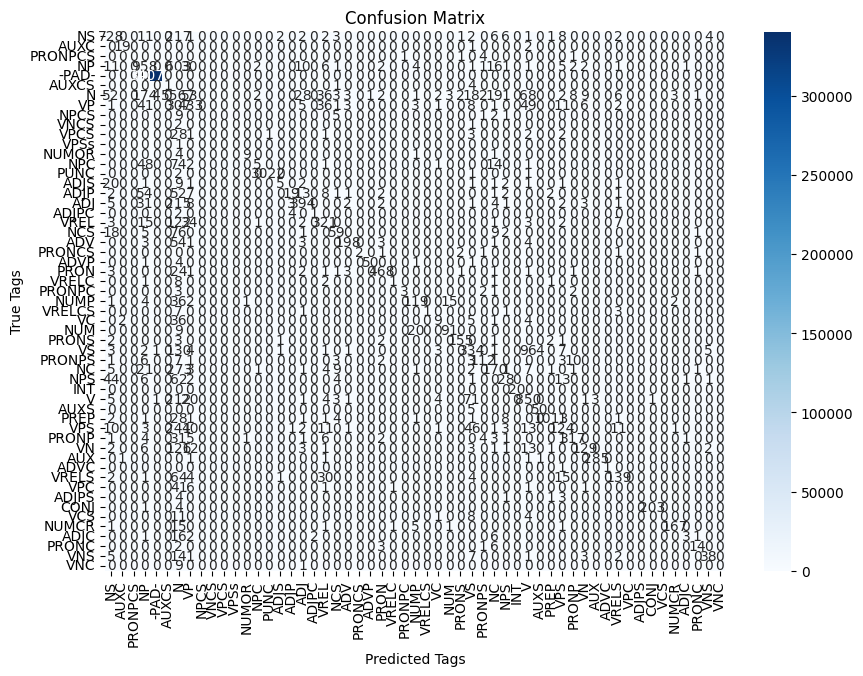

Precision: 0.9853714947095497
Recall: 0.9852938338319019
F1 Score: 0.984257859538293


In [34]:
predictions = model.predict(test_sentences_X)

predicted_tags = logits_to_tags(predictions, index_to_tag)
true_tags = logits_to_tags(test_tags_y, index_to_tag)

flat_true_tags = [tag for sublist in true_tags for tag in sublist]
flat_predicted_tags = [tag for sublist in predicted_tags for tag in sublist]

labels = [tag for tag in tag2index.keys() if tag != '-PAD-']

unique_labels = list(set(flat_true_tags) | set(flat_predicted_tags))

precision = precision_score(flat_true_tags, flat_predicted_tags, average='weighted', labels=unique_labels)
recall = recall_score(flat_true_tags, flat_predicted_tags, average='weighted', labels=unique_labels)
f1 = f1_score(flat_true_tags, flat_predicted_tags, average='weighted', labels=unique_labels)

print("Classification Report:\n", classification_report(flat_true_tags, flat_predicted_tags, target_names=unique_labels))

conf_matrix = confusion_matrix(flat_true_tags, flat_predicted_tags, labels=unique_labels)



plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Tags")
plt.ylabel("True Tags")
plt.show()

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [35]:
test_loss, test_accuracy = model.evaluate(test_sentences_X, test_tags_y)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - ignore_accuracy: 0.7590 - loss: 0.0589
Test Loss: 0.05934145301580429
Test Accuracy: 0.7576173543930054


In [36]:
def predict_tags_for_sentence(sentence, model, word2index, index2tag, max_length):
    words = sentence.split()  
    sentence_indices = [word2index.get(word, word2index['-OOV-']) for word in words]
    sentence_padded = pad_sequences([sentence_indices], maxlen=max_length, padding='post')
    predictions = model.predict(sentence_padded)    
    predicted_tags_indices = np.argmax(predictions, axis=-1)[0]      
    predicted_tags = [index_to_tag.get(idx, 'Unknown') for idx in predicted_tags_indices]
    return list(zip(words, predicted_tags))

sentence = "አላህ ከናንተ እነዚያን ያመኑትንና እነዚያንም ዕውቀትን የተሰጡትን በደረጃዎች ከፍ ያደርጋል ፡፡"
predicted_tags = predict_tags_for_sentence(sentence, model, word2index, index_to_tag, MAX_LENGTH)

for word, tag in predicted_tags:
    print(f"{word}: {tag}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
አላህ: N
ከናንተ: PRONPS
እነዚያን: PRONS
ያመኑትንና: VRELS
እነዚያንም: PRONS
ዕውቀትን: N
የተሰጡትን: VRELS
በደረጃዎች: NS
ከፍ: ADJ
ያደርጋል: V
፡፡: PUNC
